In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
plt.style.use('seaborn-white')

In [48]:
!cat data/readme.md

# Data

The data are stored as a CSV and as a pickled pandas dataframe (Python 2.7). Each data file contains 5 columns:

`count` = number of CrowdFlower users who coded each tweet (min is 3, sometimes more users coded a tweet when judgments were determined to be unreliable by CF).

`hate_speech` = number of CF users who judged the tweet to be hate speech.

`offensive_language` = number of CF users who judged the tweet to be offensive.

`neither` = number of CF users who judged the tweet to be neither offensive nor non-offensive.

`class` = class label for majority of CF users.
  0 - hate speech
  1 - offensive  language
  2 - neither


In [49]:
df = pd.read_csv('data/labeled_data.csv')

In [50]:
df.head() 

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


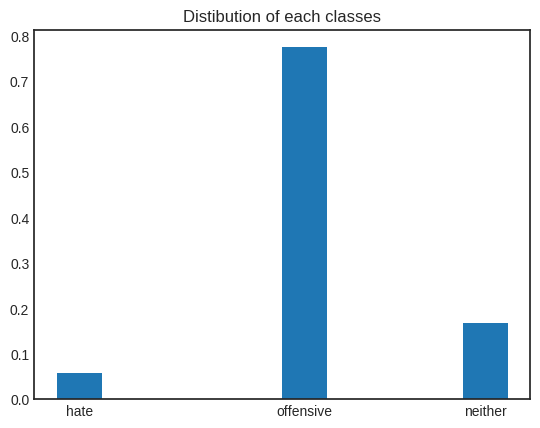

In [88]:
hist, bins_ = np.histogram(df['class'])
freq = hist / np.sum(hist)
plt.bar(bins_[:-1], freq, width=np.diff(bins_))
plt.xticks([0, 1, 1.8], ['hate', 'offensive', 'neither'])
plt.title('Distibution of each classes')
plt.show()

https://github.com/t-davidson/hate-speech-and-offensive-language/blob/master/src/Automated%20Hate%20Speech%20Detection%20and%20the%20Problem%20of%20Offensive%20Language%20Python%203.6.ipynb

TODO: create tweets features - maybe write python script for it and load it in jupyter?